# Factor Analysis Example
This ipython notebook illustrates the output that alphalens_factor_analysis.py generates with momentum and 5 day mean reversion factors. The results here do not take costs into account so are grossly overstated. The script shows what charts are looked at when assessing the explanatory power of a factor

In [ ]:
# %%

import sys

sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from zipline.pipeline.classifiers import Classifier
from zipline.utils.numpy_utils import int64_dtype
from zipline.data import bundles
from zipline.pipeline.factors import AverageDollarVolume
from zipline.pipeline import Pipeline

# data
from zipline.utils.calendar_utils import get_calendar
from data.pricing import (
    ingest_function,
    build_pipeline_engine,
    get_data_portal,
    get_pricing,
    get_symbol_from_ticker,
)
from zipline.pipeline.domain import ZA_EQUITIES
from data.sector import dict_asset_sector, dict_sector_int, create_sector

# alphas
from alpha_models.alphas import (
    momentum_sector_neutral,
    mean_reversion_5day_sector_neutral,
    mean_reversion_5day_sector_neutral_smoothed,
)

# analysis
import alphalens as al
from analytics.stats import predict_portfolio_risk, transfer_coefficient, sharpe_ratio

import yaml

In [ ]:
# %% data

with open("../config.yml", "r") as file:
    settings = yaml.safe_load(file)

EOD_BUNDLE_NAME = settings["bundles"]["bundle_name"]
factor_start_date = pd.Timestamp(settings["backtest"]["start_date"])
factor_end_date = pd.Timestamp(settings["backtest"]["end_date"])
calendar_code = settings["bundles"]["calendar_code"]
domain = ZA_EQUITIES
ingest_func = ingest_function(EOD_BUNDLE_NAME)

bundles.register(EOD_BUNDLE_NAME, ingest_func)
bundle_data = bundles.load(EOD_BUNDLE_NAME)
engine = build_pipeline_engine(bundle_data, domain)

universe = AverageDollarVolume(window_length=120).top(100)

trading_calendar = get_calendar(calendar_code)

data_portal = get_data_portal(bundle_data, trading_calendar)

# test = get_symbol_from_ticker(bundle_data, "AHV", pd.Timestamp("2018-01-22"))
# Create sector for bundle
sector_tickers = bundle_data.asset_finder.retrieve_all(bundle_data.asset_finder.sids)
sector, ticker_sector = create_sector(
    sector_tickers, dict_asset_sector, dict_sector_int
)

In [ ]:
# %%

# ## Create alpha factors

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_sector_neutral(251, universe, sector), "momentum_sector_neutral_1YR"
)

pipeline.add(
    momentum_sector_neutral(19, universe, sector), "momentum_sector_neutral_1MO"
)
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    "Mean_Reversion_5Day_Sector_Neutral",
)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    "Mean_Reversion_5Day_Sector_Neutral_Smoothed",
)
all_factors = engine.run_pipeline(pipeline, factor_start_date, factor_end_date)
all_factors["alpha"] = (
    (all_factors["momentum_sector_neutral_1YR"])
    .subtract(all_factors["momentum_sector_neutral_1MO"])
    .add(all_factors["Mean_Reversion_5Day_Sector_Neutral"] * 0.5)
)

In [ ]:
# %%

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal, trading_calendar, assets, factor_start_date, factor_end_date
)

In [ ]:
# %%

sector_names = dict((v, k) for k, v in dict_sector_int.items())
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(
        factor=factor_data,
        prices=pricing,
        periods=[1, 5],
        groupby=ticker_sector,
        groupby_labels=sector_names,
    )
    for factor, factor_data in all_factors.items()
}

unixt_factor_data = {
    factor: factor_data.set_index(
        pd.MultiIndex.from_tuples(
            [(x.timestamp(), y) for x, y in factor_data.index.values],
            names=["date", "asset"],
        )
    )
    for factor, factor_data in clean_factor_data.items()
}

/Users/evanfotopoulos/Projects/EquityBacktest/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
/Users/evanfotopoulos/Projects/EquityBacktest/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 2.6% entries from factor data: 2.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


/Users/evanfotopoulos/Projects/EquityBacktest/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
/Users/evanfotopoulos/Projects/EquityBacktest/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


/Users/evanfotopoulos/Projects/EquityBacktest/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
/Users/evanfotopoulos/Projects/EquityBacktest/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


/Users/evanfotopoulos/Projects/EquityBacktest/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
/Users/evanfotopoulos/Projects/EquityBacktest/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


/Users/evanfotopoulos/Projects/EquityBacktest/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
/Users/evanfotopoulos/Projects/EquityBacktest/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)


Dropped 2.6% entries from factor data: 2.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


The first thing to look at is a NAV plot that illustrates how a strategy of long the top quintile, short the bottom quintile would perform

<Axes: xlabel='date'>

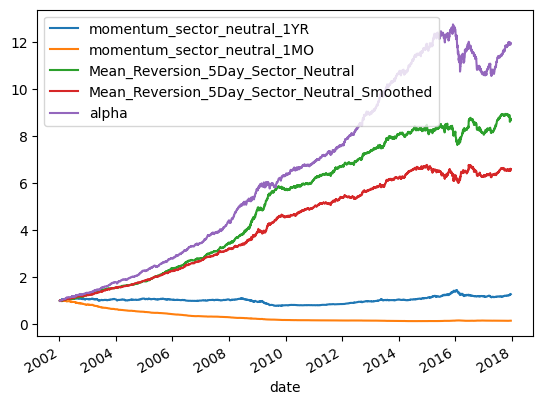

In [ ]:
# %% Quantile Analysis

ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1 + ls_factor_returns).cumprod().plot()

array([[<Axes: title={'center': 'momentum_sector_neutral_1YR'}, xlabel='factor_quantile'>,
        <Axes: title={'center': 'momentum_sector_neutral_1MO'}, xlabel='factor_quantile'>],
       [<Axes: title={'center': 'Mean_Reversion_5Day_Sector_Neutral'}, xlabel='factor_quantile'>,
        <Axes: title={'center': 'Mean_Reversion_5Day_Sector_Neutral_Smoothed'}, xlabel='factor_quantile'>],
       [<Axes: title={'center': 'alpha'}, xlabel='factor_quantile'>,
        <Axes: xlabel='factor_quantile'>],
       [<Axes: xlabel='factor_quantile'>,
        <Axes: xlabel='factor_quantile'>]], dtype=object)

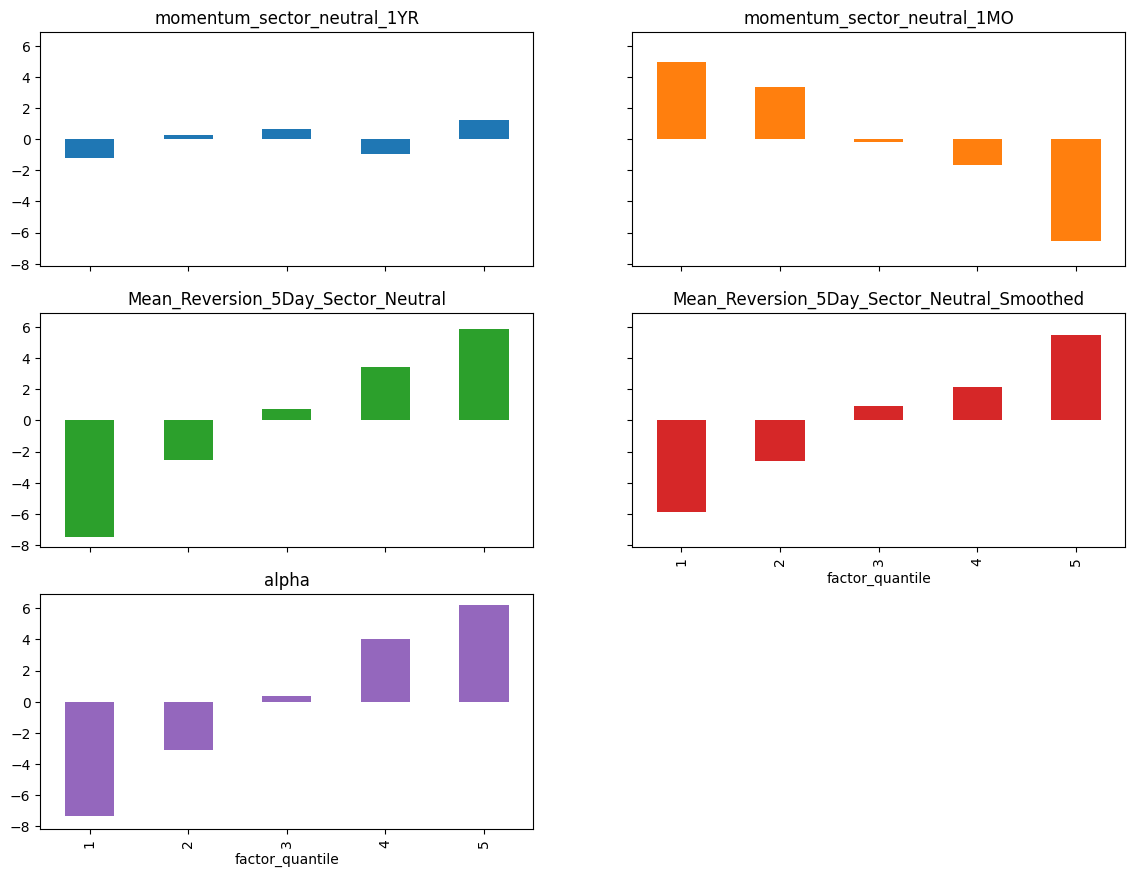

In [ ]:
# %%  Basis points per day per quantile

qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[
        0
    ].iloc[:, 0]

(10000 * qr_factor_returns).plot.bar(
    subplots=True, sharey=True, layout=(4, 2), figsize=(14, 14), legend=False
)

Next, Factor Rank Autocorrelation will be plotted to understand the turnover that would be required to trade a particular factor

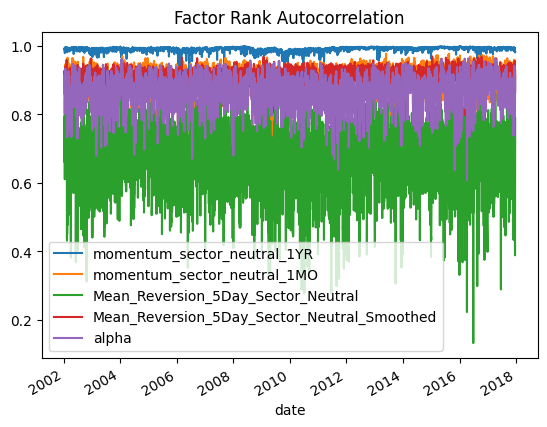

In [ ]:
# %% Turnover Analysis

ls_FRA = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")
plt.show()

In [ ]:
# %% Sharpe ratio

daily_annualization_factor = np.sqrt(252)
sharpe = sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)
print("Sharpe Ratio: {}".format(sharpe))

Sharpe Ratio: momentum_sector_neutral_1YR                    0.30
momentum_sector_neutral_1MO                   -2.27
Mean_Reversion_5Day_Sector_Neutral             2.63
Mean_Reversion_5Day_Sector_Neutral_Smoothed    2.43
alpha                                          2.79
dtype: float64
